# Panettone or Pandoro? Prototype Your Classifier with fastai!

During this holydays I started the course "**Practical Deep Learning for Coders**" by Jeremy Howard reading also the related fastbook, the Jupyter-Book from fast.ai.

Trying to practice with the lessons, I developed a Christmans-themed classifier that answers to the age-old question: "Panettone or Pandoro?".

From a Computer Vision perspective, this could seem a trivial task. However it is a good way to practice with fastai. In particular, in this notebook we are going to:
- Download images from duckduckgo to build a small dataset;
- Data cleaning (oh-oh): Not here! We are firstly prototyping a CNN and then use it to clean our data!
- Data augmentation;
- Vision learner fine-tuning;
- Data cleaning, right!
- Deploy a Gradio interface to deploy your model.

In [ ]:
# Uncomment to install the necessary packages
!pip install duckduckgo-search==4.1.1
!pip install fastai==2.7.13
!pip install fastcore==1.5.29
!pip install gradio==4.12.0

In [ ]:
# Comment to get warnings
import warnings
warnings.filterwarnings('ignore')

## Panettone vs Pandoro Classifier: Gathering Data

For many types of projects, we are able to find all the data we need online. In this notebook we are trying to implement a simple classifier. There are many images on the internet of both class that we can use. We just need a way to find them and download them. We are going to use duckduckgo as image-search engine.

### Download images

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import L

def search_images(term, max_images=30):
    # Define a function to download from ddg a max of max_images with the keyword term
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('panettone', max_images=1)
urls[0]

Searching for 'panettone'


'http://christinascucina.com/wp-content/uploads/2016/12/IMG_4263.jpg'

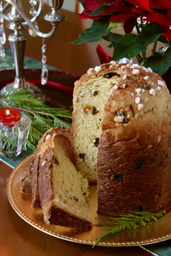

In [ ]:
# download the image and save it in the dest provided
from fastdownload import download_url
dest = r'.\panettone.jpg'
download_url(urls[0], dest, show_progress=False)

# load the image in the Image object from fastai.vision and show it
from fastai.vision.all import Image
im = Image.open(dest)
im.to_thumb(256,256)

In [ ]:
from time import sleep
from pathlib import Path
from fastai.vision.all import download_images, resize_images

path = Path('panettone_vs_pandoro')
# Let's type some strange italian words to query ddg
searches = { 'panettone':
            ['photo', 'canditi', 'uvetta', 'artigianale'],
             'pandoro':
             ['photo', 'cioccolato', 'limone', 'artigianale']}

for k,list_q in searches.items():
  for q in list_q:
      dest = (path/k)
      dest.mkdir(exist_ok=True, parents=True)
      download_images(dest, urls=search_images(f'{k} {q}',  max_images=300))
      sleep(10)
      resize_images(path/k, max_size=400, dest=path/k)


Searching for 'panettone photo'
Searching for 'panettone canditi'
Searching for 'panettone uvetta'
Searching for 'panettone artigianale'
Searching for 'pandoro photo'
Searching for 'pandoro cioccolato'
Searching for 'pandoro limone'
Searching for 'pandoro artigianale'


In [ ]:
# Let's verify that we downloaded only images!
from fastai.vision.all import verify_images, get_image_files
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

10

In [ ]:
subfolders = [folder for folder in path.iterdir() if folder.is_dir()]
for subfolder in subfolders:
    num_elements = len(list(subfolder.iterdir()))
    print(f'The number of elements in "{subfolder.name}" is: {num_elements}')

The number of elements in "panettone" is: 680
The number of elements in "pandoro" is: 686


**Remark**: You may expect data cleaning at this point, but actually, we are going to clean the data using a trained model! It could be surprising to you, but this approach could save time for you!

## Data Augmentation

Data-augmentation involves creating random variations in input data without changing its meaning. Common techniques for image data include rotation, flipping, perspective warping, brightness, and contrast adjustments. In our case, we use the `aug_transforms` function for effective augmentations on a batch of images of the same size, optimizing GPU processing.

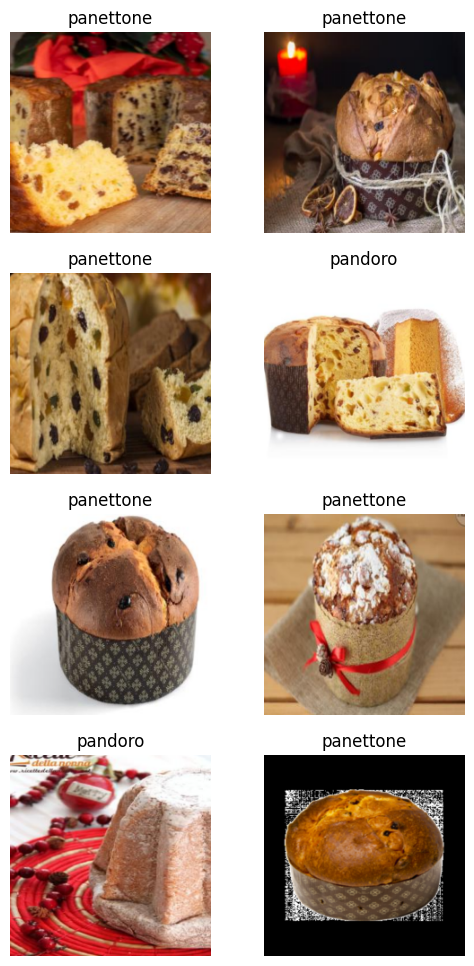

In [ ]:
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label, RandomResizedCrop, aug_transforms

data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = data_block.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=4)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

### Training Your Model, and Using It to Clean Your Data

We can now create our learner and fine-tune it :

In [ ]:
from fastai.vision.all import vision_learner, resnet18, error_rate
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Now let's see the mistakes the model is making. To visualize this, we can create a **confusion matrix**:

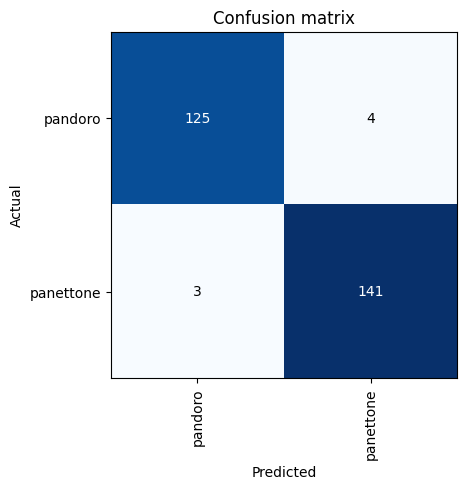

In [ ]:
from fastai.vision.all import ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't pandoro or panettone at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their loss.

The function `plot_top_loss` shows us the images with the highest loss in our dataset.

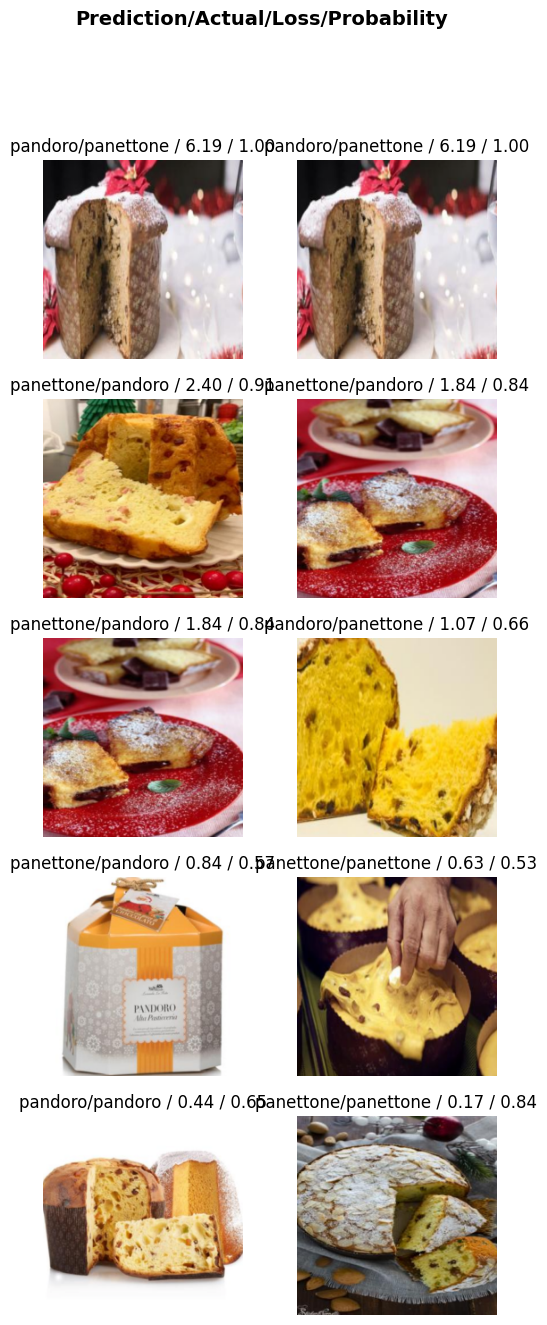

In [ ]:
interp.plot_top_losses(10, nrows=5)

This output shows that the image with the highest loss. You can see that some images have uncorrect labels or should be deleted.

The intuitive approach to doing data cleaning is to do it **before** you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [ ]:
# Select the image for each set and then run the cell below
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

You can navigate train and val and choose delete or change the labels. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you, so you should uncomment the cell below.

In [ ]:
#hide
import shutil
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

for subfolder in subfolders:
    num_elements = len(list(subfolder.iterdir()))
    print(f'The number of elements in "{subfolder.name}" is: {num_elements}')

The number of elements in "panettone" is: 339
The number of elements in "pandoro" is: 334


## Re-train the model the cleaned data!

In [ ]:
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = data_block.dataloaders(path)

from fastai.vision.all import vision_learner, resnet18, error_rate
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

## Turning Your Model into an Online Application

Now, we are going to run our model in a production environment in an online application following [online tutorial](https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html) about **Gradio + HuggingFace Spaces: A Tutorial**.

From the tutorial,
> After you train a machine learning model, the next thing to do is showcase it to the world by making a demo. Currently, the easiest way to do so is with Gradio, hosting on HuggingFace Spaces. With the Gradio framework deployed on Spaces, it takes <10 minutes to deploy a model! Let’s see how we can easily deploy a model for the world to try out with these platforms!

### Gradio interface

THe first step is creating a gradio interface in this notebook!

Firstly, we need to define out prediction function.

In [ ]:
from fastai.vision.all import PILImage
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [ ]:
predict(im)

{'pandoro': 0.001313619315624237, 'panettone': 0.9986863732337952}

Now, we can define a web-app in 3 lines of code!

In [ ]:
import gradio as gr
demo = gr.Interface(fn=predict, inputs="image", outputs="label")
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://55ae712fab9611a40f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In order to use our trained model in a HF space we need to save it. We are going to save our learner in a serialized pickle object.

In [ ]:
learn.export('model.pkl')

Now we are going to create a space using the trained model and the few lines of code from this notebook! You can check the HF space [here](https://huggingface.co/spaces/fconti/christmas_panvision).